In [1]:
import torch
import os
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import yaml
import argparse
import submitit
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.time_feature.seasonality import get_seasonality
from benchmark.data_provider.data_factory import data_provider
from utilsforecast.losses import mase, mae, smape, rmse
import csv
from training.models import SSMModel, SSMModelMulti
from training.utils import save_figure_for_latex
from tqdm import tqdm

In [2]:
import matplotlib.font_manager as font_manager

# Add these lines at the beginning of your script
import matplotlib.pyplot as plt
import seaborn as sns
from pyfonts import load_font
import matplotlib.ticker as mticker
import scienceplots  # noqa
plt.style.use(['science', 'no-latex', 'light'])
plt.rcParams["figure.constrained_layout.use"] = True
plt.rcParams['mathtext.fontset'] = 'custom'

%matplotlib inline

font = load_font(font_url='https://github.com/misuchiru03/font-times-new-roman/blob/master/Times%20New%20Roman.ttf?raw=true')

In [3]:
font

In [4]:
MAX_LENGTH = 512
pred_style = 'multipoint'
model_name = "latest_mi_2l_1024e_nores_30-512cl_m2_norm_dconv_i5e5_lr1e-07_mp0.5_initlr1e-05_t300r_pm0.7_nPer_pl10-60_subday_subfreq0.2_perfreq0.5_d0.05_s0.05"

# The ones in the paper
REAL_DATASETS = {
    "nn5_daily_without_missing": 56,
    "nn5_weekly": 8,
    "covid_deaths": 30,
    "weather": 30,
    "hospital": 12, 
    "fred_md": 12,
    "car_parts_without_missing": 12,
    "traffic": 24,
    "m3_monthly": 18,
    "ercot": 24,
    "m1_monthly": 18,
    "m1_quarterly": 8,
    "cif_2016": 12,
    "electricity_hourly": 24,
    "m4_daily": 14,
    "exchange_rate": 30,
#     ## "ett_hourly": 24,
    "m3_quarterly": 8,
    "tourism_monthly": 24,
    "tourism_quarterly": 8,
}


dataframes = []

for dataset_name in REAL_DATASETS.keys():
    
    with open(f'../../data/real_data_evals/{model_name}/{pred_style}/{dataset_name}_{MAX_LENGTH}.yml', 'r') as fp:
        data = yaml.load(fp, yaml.Loader)  
        
    data = pd.DataFrame(data).transpose()    
    data.reset_index(drop=False, inplace=True)     
    data['cl'] = data['index'].apply(lambda x: int(x.split('_')[0]))
    data['pl'] = data['index'].apply(lambda x: int(x.split('_')[1]))
    data.drop(columns=['index'], inplace=True)
    data['dataset'] = dataset_name
    dataframes.append(data)
MambaPFN_df = pd.concat(dataframes)
MambaPFN_df.rename(columns={'mase': 'Mamba4Cast'}, inplace=True)
MambaPFN_df = MambaPFN_df[MambaPFN_df['cl'] == 512].set_index('dataset')

In [14]:
ablation_models = {
    'latest_mi_2l_1024e_nores_30-512cl_m2_norm_dconv_i5_lr1e-07_mp0.5_initlr1e-05_t300r_pm0.7_nPer_pl10-60_subday_subfreq0.2_perfreq0.5_d0.05_s0.05': 'Mamba4Cast Init. Conv.',
    'latest_mi_2l_1024e_nores_30-512cl_m2_norm_dconv_i5e5_lr1e-07_mp0.5_initlr1e-05_t300r_pm0.0_nPer_pl10-60_subday_subfreq0.2_perfreq0.5_d0.05_s0.05': 'Mamba4Cast FPFN Prior',
    'latest_mi_2l_1024e_nores_30-512cl_m2_norm_lr1e-07_mp0.5_initlr1e-05_t300r_pm0.7_nPer_pl10-60_subday_subfreq0.2_perfreq0.5_d0.05_s0.05_new': 'Mamba4Cast No Conv.',
    'latest_mi_2l_1024e_nores_30-512cl_m2_norm_dconv_i5e5_lr1e-07_mp0.5_initlr1e-05_t300r_pm1.0_nPer_pl10-60_subday_subfreq0.2_perfreq0.5_d0.05_s0.05': 'Mamba4Cast GP Prior',
}

MAX_LENGTH = 512
pred_style = 'multipoint'

ablation_dfs = []
for model_name, label in ablation_models.items():
    dataframes = []
    for dataset_name in REAL_DATASETS.keys():
        
        with open(f'../../data/real_data_evals/{model_name}/{pred_style}/{dataset_name}_{MAX_LENGTH}.yml', 'r') as fp:
            data = yaml.load(fp, yaml.Loader)  
            
        data = pd.DataFrame(data).transpose()
        data.reset_index(drop=False, inplace=True)
        data['cl'] = data['index'].apply(lambda x: int(x.split('_')[0]))
        data['pl'] = data['index'].apply(lambda x: int(x.split('_')[1]))
        data = data[data['cl'] == MAX_LENGTH].drop(columns=['index','mae','rmse', 'smape', 'cl', 'pl'])
        dataframes.append(data)
    res_df = pd.concat(dataframes).rename(columns={'mase': label}).reset_index(drop=True)
    ablation_dfs.append(res_df)
ablation_df = pd.concat(ablation_dfs,axis=1)
ablation_df['dataset'] = REAL_DATASETS.keys()
ablation_df.set_index('dataset', inplace=True)

In [15]:
ablation_df

,Mamba4Cast Init. Conv.,Mamba4Cast FPFN Prior,Mamba4Cast No Conv.,Mamba4Cast GP Prior
dataset,,,,
nn5_daily_without_missing,0.950444,0.881409,1.456878,0.847644
nn5_weekly,0.954996,0.983258,0.917007,0.943899
covid_deaths,7.477723,10.867059,8.336933,7.542686
weather,0.775867,0.799275,0.750674,0.727154
hospital,0.809398,0.850028,0.839337,0.809790
fred_md,0.557667,0.991388,0.578583,0.510361
car_parts_without_missing,1.079281,1.079752,1.111517,1.112717
traffic,1.143021,1.075335,2.002316,1.209945
m3_monthly,0.871365,1.307625,0.995138,0.905697


In [8]:
MambaPFN_df[MambaPFN_df["cl"]==512]

,mae,Mamba4Cast,rmse,smape,cl,pl
dataset,,,,,,
nn5_daily_without_missing,3.706930e+00,0.806881,5.296473e+00,0.108197,512,56
nn5_weekly,1.504755e+01,0.947167,1.867364e+01,0.058296,512,8
covid_deaths,2.159965e+02,6.893941,2.544364e+02,0.212573,512,30
weather,2.107507e+00,0.691905,2.728658e+00,0.304538,512,30
hospital,2.056398e+01,0.801457,2.458607e+01,0.092586,512,12
fred_md,1.854546e+03,0.563442,2.073639e+03,0.055678,512,12
car_parts_without_missing,5.523887e-01,0.993087,7.672166e-01,0.909063,512,12
traffic,1.715982e-02,1.124867,2.602533e-02,0.165008,512,24
m3_monthly,6.336557e+02,0.864866,7.654014e+02,0.071347,512,18


***Way worse datasets (diff>0.7)*** 
- tourism_quarterly
- 

***Just worse (diff>0.7)***
- tourism_monthly
- m3_quarterly

In [7]:
MambaPFN_df[MambaPFN_df["dataset"].apply(lambda x: x not in ["covid_deaths", "m4_daily", "electricity_hourly"])].drop(columns=["dataset"]).groupby(["cl"]).mean()

,mae,MambaPFN,rmse,smape,pl
cl,,,,,
256,113394.234375,1.112851,120506.281250,0.143267,19.0
512,113395.171875,1.093046,120510.179688,0.142339,19.0


In [8]:
MambaPFN_df.drop(columns=["dataset"]).groupby(['cl']).mean()

,mae,MambaPFN,rmse,smape,pl
cl,,,,,
256,95528.890625,3.309535,101526.812500,0.138431,19.578947
512,95529.265625,3.311640,101530.179688,0.137639,19.578947


In [25]:
chronos_small_results = {    
    "nn5_daily_without_missing": 0.62,
    "nn5_weekly": 0.93,
    "covid_deaths": 42.689,
    "weather": 0.839,
    "hospital": 0.819, 
    "fred_md": 0.576,
    "car_parts_without_missing": 0.891,
    "traffic": 0.833,
    "m3_monthly": 0.883,
    "ercot": 0.577,
    "m1_monthly": 1.163,
    "m1_quarterly": 1.776,
    "cif_2016": 1.016,
    "electricity_hourly": 1.5,
    "m4_daily": 3.112,
    "exchange_rate": 3.357,
#     ## "ett_hourly": 24,
    "m3_quarterly": 1.25,
    "tourism_monthly": 1.891,
    "tourism_quarterly": 1.727,
    }

chronos_large_results = {    
    "nn5_daily_without_missing": 0.57,
    "nn5_weekly": 0.917,
    "covid_deaths": 42.762,
    "weather": 0.827,
    "hospital": 0.815, 
    "fred_md": 0.592,
    "car_parts_without_missing": 0.911,
    "traffic": 0.798,
    "m3_monthly": 0.853,
    "ercot": 0.556,
    "m1_monthly": 1.086,
    "m1_quarterly": 1.699,
    "cif_2016": 0.985,
    "electricity_hourly": 1.457,
    "m4_daily": 3.099,
    "exchange_rate": 3.231,
#     ## "ett_hourly": 24,
    "m3_quarterly": 1.170,
    "tourism_monthly": 1.741,
    "tourism_quarterly": 1.660,
    }

forecast_pfn_results = {    
    "nn5_daily_without_missing": 1.375,
    "nn5_weekly": 1.349,
    "covid_deaths": 91.515,
    "weather": 2.003,
    "hospital": 1.775, 
    "fred_md": 2.621,
    "car_parts_without_missing": 2.657,
    "traffic": 1.909,
    "m3_monthly": 2.240,
    "ercot": 3.975,
    "m1_monthly": 2.172,
    "m1_quarterly": 9.931,
    "cif_2016": 3.588,
    "electricity_hourly": 5.0,
    # "m4_daily": ,
    "exchange_rate": 7.583,
#     ## "ett_hourly": 24,
    "m3_quarterly": 10.176,
    "m4_daily": 5.0,
    "tourism_monthly": 4.348,
    "tourism_quarterly": 5.595,
    }

seasonal_naive_results = {    
    "nn5_daily_without_missing": 1.292,
    "nn5_weekly": 1.063,
    "covid_deaths": 46.912,
    "weather": 1.004,
    "hospital": 0.921, 
    "fred_md": 1.101,
    "car_parts_without_missing": 1.201,
    "traffic": 1.077,
    "m3_monthly": 1.146,
    "ercot": 0.761,
    "m1_monthly": 1.314,
    "m1_quarterly": 2.078,
    "cif_2016": 1.289,
    "electricity_hourly": 1.840,
    "m4_daily": 3.278,
    "exchange_rate": 1.74,
#     ## "ett_hourly": 24,
    "m3_quarterly": 1.425,
    "tourism_monthly": 1.631,
    "tourism_quarterly": 1.699,
    }

print(f"chronos_small_results: {np.mean(list(chronos_small_results.values()))}")
print(f"chronos_large_results: {np.mean(list(chronos_large_results.values()))}")
print(f"forecast_pfn_results: {np.mean(list(forecast_pfn_results.values()))}")
print(f"seasonal_naive_results: {np.mean(list(seasonal_naive_results.values()))}")

chronos_small_results: 3.497315789473684
chronos_large_results: 3.459421052631579
forecast_pfn_results: 8.674315789473685
seasonal_naive_results: 3.8301052631578942


In [26]:
chronos_small_df = pd.DataFrame({"dataset":list(chronos_small_results.keys()), "Chronos-S":list(chronos_small_results.values())})
chronos_large_df = pd.DataFrame({"dataset":list(chronos_large_results.keys()), "Chronos-L":list(chronos_large_results.values())})
forecast_pfn_df = pd.DataFrame({"dataset":list(forecast_pfn_results.keys()), "ForecastPFN":list(forecast_pfn_results.values())})
seasonal_naive_df = pd.DataFrame({"dataset":list(seasonal_naive_results.keys()), "Seas. Naive":list(seasonal_naive_results.values())})

df_joint = chronos_small_df.join(MambaPFN_df[MambaPFN_df["cl"]==512][["Mamba4Cast", "dataset"]].set_index("dataset"), on="dataset", rsuffix="_MambaPFN")
df_joint["diff"] = df_joint["Mamba4Cast"] - df_joint["Chronos-S"]
df_joint["how_bad"] = df_joint["diff"].apply(lambda x: "Way Worse" if x > 0.7 else "Worse" if x > 0.2 else "Nearly Equal" if x > -0.2 else "Better")

In [27]:
df_joint[df_joint["how_bad"]!="Nearly Equal"].sort_values(by="diff", ascending=False)

,dataset,Chronos-S,Mamba4Cast,diff,how_bad
7,traffic,0.833,1.124867,0.291867,Worse
17,tourism_monthly,1.891,1.587995,-0.303005,Better
14,m4_daily,3.112,1.169186,-1.942814,Better
15,exchange_rate,3.357,1.409586,-1.947414,Better
2,covid_deaths,42.689,6.893941,-35.795059,Better


In [51]:
result_df = MambaPFN_df
result_df = result_df.join(chronos_small_df.set_index("dataset"), on="dataset")
result_df = result_df.join(chronos_large_df.set_index("dataset"), on="dataset")
result_df = result_df.join(forecast_pfn_df.set_index("dataset"), on="dataset")
result_df = result_df.join(seasonal_naive_df.set_index("dataset"), on="dataset")

In [52]:
result_df = result_df[result_df['cl']==512].set_index('dataset')[['MambaPFN', 'ForecastPFN', 'Chronos-S', 'Chronos-L', 'Seas. Naive']]
result_df

,MambaPFN,ForecastPFN,Chronos-S,Chronos-L,Seas. Naive
dataset,,,,,
nn5_daily_without_missing,0.567701,1.375,0.620,0.570,1.292
nn5_weekly,0.947197,1.349,0.930,0.917,1.063
covid_deaths,40.787849,91.515,42.689,42.762,46.912
weather,0.969959,2.003,0.839,0.827,1.004
hospital,0.801427,1.775,0.819,0.815,0.921
fred_md,0.563366,2.621,0.576,0.592,1.101
car_parts_without_missing,0.992975,2.657,0.891,0.911,1.201
traffic,1.124700,1.909,0.833,0.798,1.077
m3_monthly,0.864894,2.240,0.883,0.853,1.146


### old code above

In [16]:
new_chronos_results = pd.read_csv("../../data/autogluonts_evaluation_results/autogluonts_metrics.csv")
stat_results = pd.read_csv("../../data/autogluonts_evaluation_results/autogluonts_metrics_stat.csv")
new_chronos_results = new_chronos_results.rename(columns={'Unnamed: 0': 'dataset'}).set_index('dataset') * -1
stat_results = stat_results.rename(columns={'Unnamed: 0': 'dataset'}).set_index('dataset') * -1

In [17]:
new_autogluon_results = stat_results.join(new_chronos_results, rsuffix="_stat")
new_autogluon_results.fillna(0.99, inplace=True)

In [18]:
result_df = new_autogluon_results.join(MambaPFN_df[['Mamba4Cast']], on='dataset', rsuffix="_mamba")
result_df = result_df.join(ablation_df, on="dataset")
result_df.dropna(inplace=True)

In [19]:
result_df.rename(columns={'Mamba4Cast': 'Mamba4Cast', 'Chronos_small': 'Chronos-Small', 'Chronos_base': 'Chronos-Base', 'SeasonalNaive': 'S-Naive'}, inplace=True)

In [20]:
result_df

,AutoARIMA,DeepAR,Chronos-Small,Chronos-Base,S-Naive,Chronos_small_mod,Chronos_base_mod,Mamba4Cast,Mamba4Cast Init. Conv.,Mamba4Cast FPFN Prior,Mamba4Cast No Conv.,Mamba4Cast GP Prior
dataset,,,,,,,,,,,,
nn5_daily_without_missing,0.831808,0.793450,0.833885,0.809191,0.952277,0.825788,0.805466,0.806881,0.950444,0.881409,1.456878,0.847644
nn5_weekly,1.699745,0.861056,0.949987,0.941844,1.062848,0.945599,0.942579,0.947167,0.954996,0.983258,0.917007,0.943899
covid_deaths,6.058734,8.917449,7.376048,7.461202,8.977361,7.332566,7.459322,6.893941,7.477723,10.867059,8.336933,7.542686
weather,0.705461,0.768583,0.626933,0.588752,0.813488,0.627841,0.588780,0.691905,0.775867,0.799275,0.750674,0.727154
hospital,0.836088,0.774761,0.814478,0.815156,0.920528,0.810233,0.810610,0.801457,0.809398,0.850028,0.839337,0.809790
fred_md,0.519066,0.588438,0.399022,0.398733,0.934713,0.400386,0.400324,0.563442,0.557667,0.991388,0.578583,0.510361
car_parts_without_missing,1.180328,0.747039,0.817372,0.831569,1.126881,0.819594,0.829741,0.993087,1.079281,1.079752,1.111517,1.112717
traffic,1.326796,0.481978,0.380371,0.370416,0.753200,0.381232,0.370416,1.124867,1.143021,1.075335,2.002316,1.209945
m3_monthly,1.033304,1.056269,0.890177,0.865779,1.146205,0.891418,0.865650,0.864866,0.871365,1.307625,0.995138,0.905697


In [22]:
abl_cols = ['Mamba4Cast', 'Mamba4Cast Init. Conv.', 'Mamba4Cast FPFN Prior', 'Mamba4Cast No Conv.', 'Mamba4Cast GP Prior']

for i in abl_cols:
    print(f'{i} - mean: {result_df[i].mean()} +- std: {result_df[i].std()}')

Mamba4Cast - mean: 1.432087779045105 +- std: 1.4563310146331787
Mamba4Cast Init. Conv. - mean: 1.4985699653625488 +- std: 1.5784391164779663
Mamba4Cast FPFN Prior - mean: 2.160306930541992 +- std: 2.4302175045013428
Mamba4Cast No Conv. - mean: 1.9700177907943726 +- std: 1.8060098886489868
Mamba4Cast GP Prior - mean: 1.4909133911132812 +- std: 1.6096571683883667


In [59]:
result_df.index

Index(['nn5_daily_without_missing', 'nn5_weekly', 'covid_deaths', 'weather',
       'hospital', 'fred_md', 'car_parts_without_missing', 'traffic',
       'm3_monthly', 'ercot', 'm1_monthly', 'm1_quarterly', 'cif_2016',
       'exchange_rate', 'm3_quarterly', 'tourism_monthly',
       'tourism_quarterly'],
      dtype='object', name='dataset')

In [60]:
cols_to_keep = ['nn5_daily_without_missing', 'nn5_weekly', 'weather',
       'hospital', 'fred_md', 'car_parts_without_missing', 'traffic',
       'm3_monthly', 'ercot', 'm1_monthly', 'cif_2016',
       'exchange_rate', 'tourism_monthly', 'electricity_hourly', 'm3_quarterly']
reduced_res_df = result_df[result_df.index.isin(cols_to_keep)]
reduced_res_df.mean()

MambaPFN         0.991965
ForecastPFN      3.412214
Chronos-S        1.117500
Chronos-L        1.075143
Seas. Naive      1.211786
Mamba4Cast       0.989155
AutoARIMA        1.124768
DeepAR           1.072952
Chronos-Small    0.934994
Chronos-Base     0.906592
S-Naive          1.091561
dtype: float64

In [61]:
rank_df = result_df.iloc[:, 5:].copy()
# Rank the methods for each dataset
for dataset in rank_df.index:
    rank_df.loc[dataset] = rank_df.loc[dataset].rank(method='min', ascending=True)

# If you want integer ranks, you can round the values
rank_df = rank_df.round().astype(int)

# Display the ranked dataframe
rank_df

,Mamba4Cast,AutoARIMA,DeepAR,Chronos-Small,Chronos-Base,S-Naive
dataset,,,,,,
nn5_daily_without_missing,2,4,1,5,3,6
nn5_weekly,3,6,1,4,2,5
covid_deaths,2,1,5,3,4,6
weather,3,4,5,2,1,6
hospital,2,5,1,3,4,6
fred_md,4,3,5,2,1,6
car_parts_without_missing,4,6,1,2,3,5
traffic,5,6,3,2,1,4
m3_monthly,1,4,5,3,2,6


# Visualizations

## Critical Difference Diagram

In [62]:
from Orange.evaluation.scoring import graph_ranks
import matplotlib.pyplot as plt
import Orange

from matplotlib import rc
%matplotlib inline

In [63]:
# Convert the ranked dataframe to the format needed by Orange
avranks = rank_df.mean().values
names = rank_df.columns.tolist()
N = len(rank_df)  # number of datasets
k = len(names)  # number of methods

plt.figure(figsize=(4, 2))
# Create the CD diagram
cd = Orange.evaluation.compute_CD(avranks, N, alpha="0.05", test="nemenyi")
fig = Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=3, textspace=0)

plt.savefig('../../data/plots/critical_difference_diagram.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
save_figure_for_latex(plt.gcf(), '../../data/plots/critical_difference_diagram_new_eval_stat')

/scratch/fr_sb986_o05i14/ipykernel_33264/1749653172.py:9: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = Orange.evaluation.compute_CD(avranks, N, alpha="0.05", test="nemenyi")
/scratch/fr_sb986_o05i14/ipykernel_33264/1749653172.py:10: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  fig = Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=3, textspace=0)


Figure saved as ../../data/plots/critical_difference_diagram_new_eval_stat.pdf


<Figure size 400x200 with 0 Axes>

## Barplot for results

In [64]:
result_df_long = result_df[['Chronos-Base', 'Mamba4Cast', 'DeepAR', 'Chronos-Small', 'AutoARIMA', 'S-Naive']].reset_index(drop=False).melt(id_vars='dataset', var_name='method', value_name='metric')

In [65]:
result_df_long

,dataset,method,metric
0,nn5_daily_without_missing,Chronos-Base,0.809191
1,nn5_weekly,Chronos-Base,0.941844
2,covid_deaths,Chronos-Base,7.461202
3,weather,Chronos-Base,0.588752
4,hospital,Chronos-Base,0.815156
...,...,...,...
97,cif_2016,S-Naive,0.990000
98,exchange_rate,S-Naive,1.459856
99,m3_quarterly,S-Naive,1.425344
100,tourism_monthly,S-Naive,1.630940


In [66]:
result_df_long = result_df_long[(result_df_long['method']!='ForecastPFN')]

In [67]:
plt.figure(figsize=(7, 5))


boxprops = {'edgecolor': 'k', 'linewidth': 3, 'alpha': 0.7}
lineprops = {'color': 'k', 'linewidth': 2}
boxplot_kwargs = {'boxprops': boxprops, 'medianprops': lineprops,
                  'whiskerprops': lineprops, 'capprops': lineprops,
                  'width': 0.75, 'palette': 'flare'}

stripplot_kwargs = {'linewidth': 0.6, 'size': 10, 'alpha': 0.9,
                    'palette': 'flare'}

sns.boxplot(data=result_df_long, x='method', y='metric', showfliers=False, **boxplot_kwargs)
sns.stripplot(data=result_df_long[result_df_long['dataset']!='covid_deaths'], x='method', y='metric',
              jitter=True, **stripplot_kwargs)
plt.xlabel("").set_visible(False)
plt.ylabel("Mean MASE", fontsize=18, font=font)
plt.xticks(fontsize=16, rotation=20)
plt.yticks(fontsize=16)


save_figure_for_latex(plt.gcf(), '../../data/plots/mase_box_plot')

Figure saved as ../../data/plots/mase_box_plot.pdf


## Inference Time Plot

In [23]:
with open(f'../../data/inference_time_exp/inference_time_exp.yaml', 'r') as fp:
    inf_data = yaml.load(fp, yaml.Loader)

In [28]:
inf_df = pd.DataFrame(inf_data)
inf_df.reset_index(drop=False, inplace=True)

In [29]:
inf_df['cl'] = inf_df['index'].apply(lambda x: int(x.split('_')[0]))
inf_df['pl'] = inf_df['index'].apply(lambda x: int(x.split('_')[1]))
inf_df['batch_size'] = inf_df['index'].apply(lambda x: int(x.split('_')[2]))
inf_df.drop(columns=['index'], inplace=True)

In [30]:
inf_df = inf_df[inf_df["cl"]==512]
inf_df = inf_df[inf_df['pl'].isin(np.linspace(8, 50, 10).astype(int).tolist())]

In [31]:
inf_df['Chronos-S'] = inf_df['chronos-small'].apply(lambda x: np.mean(x) if isinstance(x, list) else x)
inf_df['MambaPFN'] = inf_df['mambapfn'].apply(lambda x: np.mean(x) if isinstance(x, list) else x)

In [32]:
inf_df

,chronos-base,chronos-small,mambapfn,cl,pl,batch_size,Chronos-S,MambaPFN
0,[87.31267714500427],"[27.219850540161133, 27.490111351013184, 27.37...","[5.3791420459747314, 5.416300535202026, 5.3778...",512,12,64,27.362928,5.391089
1,[117.52687191963196],"[37.07027792930603, 37.132500648498535, 37.117...","[5.412783861160278, 5.440005302429199, 5.43621...",512,17,64,37.106727,5.429669
2,[148.18311953544617],"[46.98251724243164, 47.041757106781006, 46.991...","[5.462329149246216, 5.486844539642334, 5.48106...",512,22,64,47.005135,5.476745
3,[172.64834904670715],"[55.04875469207764, 55.01976227760315]","[5.545573949813843, 5.547827243804932, 5.54328...",512,26,64,55.034258,5.545561
4,[203.388347864151],"[64.96249866485596, 64.94345545768738]","[5.580306768417358, 5.587087631225586, 5.58850...",512,31,64,64.952977,5.585299
5,[234.41473245620728],"[74.92273616790771, 74.88330388069153]","[5.66205906867981, 5.666448593139648, 5.688185...",512,36,64,74.903020,5.672231
6,[259.38391160964966],"[83.01793050765991, 82.968740940094]","[5.691359519958496, 5.7016236782073975, 5.7143...",512,40,64,82.993336,5.702450
7,[290.7661190032959],"[93.14747905731201, 93.14309787750244]","[5.765187501907349, 5.759836196899414, 5.76174...",512,45,64,93.145288,5.762256
9,[322.4876594543457],"[103.38527321815491, 103.36501002311707]","[5.774294376373291, 5.768427848815918, 5.77041...",512,50,64,103.375142,5.771045
10,[63.13425850868225],"[21.646970748901367, 19.805275678634644, 19.59...","[5.37181830406189, 5.368938684463501]",512,8,64,20.347646,5.370378


In [43]:

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.pointplot(data=inf_df, x='pl', y='Chronos-S', hue='batch_size', markers='o', scale=1.75, log_scale=[False, True], ax=ax, palette=sns.color_palette("flare"))
sns.pointplot(data=inf_df, x='pl', y='MambaPFN', hue='batch_size',ax=ax, markers='D', scale=1.75, log_scale=[False, True], palette=sns.color_palette("dark:#5A9_r", as_cmap=True))
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('Prediction Length', fontsize=18)
ax.set_ylabel('Inference Time - Log Scale (s)', fontsize=18)

# Create custom legend
batch_sizes = [1, 64, 128]
models = ['Chronos-S', 'MambaPFN']
markers = ['^', 'D']
# Create color palettes
flare_palette = sns.color_palette("flare", n_colors=3)
dark_palette = sns.color_palette("dark:#5A9_r", n_colors=3)

# Combine the palettes
colors = flare_palette + dark_palette

legend_elements = []
for i, model in enumerate(models):
    for j, batch_size in enumerate(batch_sizes):
        label = f'{model} - {batch_size}'
        legend_elements.append(plt.Line2D([0], [0], marker=markers[i], color=colors[i*3 + j], 
                                          label=label, linestyle='None', markersize=9))

# Add the custom legend
ax.legend(handles=legend_elements, title='Model - Batch Size', fontsize=12, title_fontsize=13, loc='lower left',
          bbox_to_anchor=(0,1.02,1,0.1), mode='expand', fancybox=True, ncols=3)


save_figure_for_latex(plt.gcf(), '../../data/plots/inference_time_plot')

Figure saved as ../../data/plots/inference_time_plot.pdf


## Sine wave plot (different place to avoid the gpu computation)

In [24]:
model_name = "latest_mi_2l_1024e_nores_30-512cl_m2_norm_dconv_i5e5_lr1e-07_mp0.5_initlr1e-05_t300r_pm0.7_nPer_pl10-60_subday_subfreq0.2_perfreq0.5_d0.05_s0.05"
pred_df = pd.read_pickle(f'../../data/sine_exp/{model_name}/36_512_16pi_am.pkl')
cl = 512
pl = 36

In [52]:
# saving the image of some predictions
contexts_to_eval = [16,32,128,256,512]
cls = contexts_to_eval # can edit this to change the context lengths to plot
# reverse the order of the context lengths to plot
cls = cls[::-1]
plots = ['sin', 'sinal', 'sinms', 'sinml']
fig, axes = plt.subplots(2, 2, figsize=(15, 5))
plt.rcParams["figure.autolayout"] = True
colors = sns.color_palette("viridis", n_colors=len(cls))
    
for i, plot in enumerate(plots):
    ax = axes.flatten()[i]
    data = pred_df[pred_df['id'] == str(cls[0])].reset_index(drop=True)
    data['seq'] = data.index
    sns.lineplot(data=data, x='seq', y=f'target_{plot}', ax=ax, c='red', linewidth=2.5, alpha=0.5)
    ax.axvline(x = cls[0], color='black', linestyle='solid', linewidth=2)
    for j, cl in enumerate(cls):
        data = pred_df[pred_df['id'] == str(cl)].reset_index(drop=True)
        data['seq'] = np.arange((max(cls)-cl), max(cls)+pl)
        sns.lineplot(data=data, x='seq', y=f'pred_{plot}', ax=ax, c=colors[j], linewidth=1.5)
        ax.axvline(x=max(cls)-cl, color=colors[j], linestyle='dashed', linewidth=2)
        plt.tight_layout()
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        
    print(plt.xticks())
    if i in [0,1]:
        ax.set_xticks([])

legend_elements = [plt.Line2D([0], [0], color='red', label='Target', linestyle='solid', linewidth=3)]
for i, cl in enumerate(cls):
    label = cl
    legend_elements.append(plt.Line2D([0], [0], color=colors[i], 
                                    label=label, linestyle='solid', linewidth=3))

# Add the custom legend
fig.legend(handles=legend_elements, fontsize=15, loc='upper center',
        bbox_to_anchor=(0.2,1.02,0.6,0.04), mode='expand', fancybox=True, ncols=6)
    
fig_savename = f'../../data/plots/sine_exp_plot'
save_figure_for_latex(fig=fig, filename=fig_savename)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), [Text(0.0, 0, '$\\mathdefault{0.0}$'), Text(0.2, 0, '$\\mathdefault{0.2}$'), Text(0.4, 0, '$\\mathdefault{0.4}$'), Text(0.6000000000000001, 0, '$\\mathdefault{0.6}$'), Text(0.8, 0, '$\\mathdefault{0.8}$'), Text(1.0, 0, '$\\mathdefault{1.0}$')])
(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), [Text(0.0, 0, '$\\mathdefault{0.0}$'), Text(0.2, 0, '$\\mathdefault{0.2}$'), Text(0.4, 0, '$\\mathdefault{0.4}$'), Text(0.6000000000000001, 0, '$\\mathdefault{0.6}$'), Text(0.8, 0, '$\\mathdefault{0.8}$'), Text(1.0, 0, '$\\mathdefault{1.0}$')])
(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), [Text(0.0, 0, '$\\mathdefault{0.0}$'), Text(0.2, 0, '$\\mathdefault{0.2}$'), Text(0.4, 0, '$\\mathdefault{0.4}$'), Text(0.6000000000000001, 0, '$\\mathdefault{0.6}$'), Text(0.8, 0, '$\\mathdefault{0.8}$'), Text(1.0, 0, '$\\mathdefault{1.0}$')])
(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.]), [Text(-100.0, 0, '$\\mathdefault{−100}$'), Text(0.0, 0, '$\\mathdefault{0}$'), 

In [12]:
np.linspace(64,512,8).astype(int).tolist()

[64, 128, 192, 256, 320, 384, 448, 512]

In [39]:
sns.color_palette("viridis", 6)[1]

(0.212395, 0.359683, 0.55171)

## General setup

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

pred_style = 'multipoint'
model_name = "latest_mi_2l_1024e_nores_30-512cl_m2_norm_dconv_i5e5_lr1e-07_mp0.5_initlr1e-05_t300r_pm0.7_nPer_pl10-60_subday_subfreq0.2_perfreq0.5_d0.05_s0.05"
cl = 512
sampled_ids = 6

## Plots for the Paper

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(12, 48))



## Way worse datasets

In [18]:
df_joint

,dataset,Chronos-S,MambaPFN,diff,how_bad
0,nn5_daily_without_missing,0.620,0.567701,-0.052299,Nearly Equal
1,nn5_weekly,0.930,0.947197,0.017197,Nearly Equal
2,covid_deaths,42.689,40.787849,-1.901151,Better
3,weather,0.839,0.969959,0.130959,Nearly Equal
4,hospital,0.819,0.801427,-0.017573,Nearly Equal
5,fred_md,0.576,0.563366,-0.012634,Nearly Equal
6,car_parts_without_missing,0.891,0.992975,0.101975,Nearly Equal
7,traffic,0.833,1.124700,0.291700,Worse
8,m3_monthly,0.883,0.864894,-0.018106,Nearly Equal
9,ercot,0.577,0.707455,0.130455,Nearly Equal


In [19]:
ww_dfs = {}

for dataset in list(df_joint.dataset.values):
    pl = REAL_DATASETS[dataset]
    ww_dfs[dataset] = {}
    ww_dfs[dataset]["train_df"] = pd.read_csv(f'../../data/real_data_evals/{model_name}/{pred_style}/{dataset}_train_df_{cl}_{pl}.csv')
    ww_dfs[dataset]["pred_df"] = pd.read_csv(f'../../data/real_data_evals/{model_name}/{pred_style}/{dataset}_pred_df_{cl}_{pl}.csv')
    ww_dfs[dataset]["train_df"]['pred'] = ww_dfs[dataset]["train_df"]['target']
    

### Ercot

Our guess is that we didn't train on seasonality for subday (hourly info) maybe that's why it can't capture it here

[0 5 4 3 6 2]


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


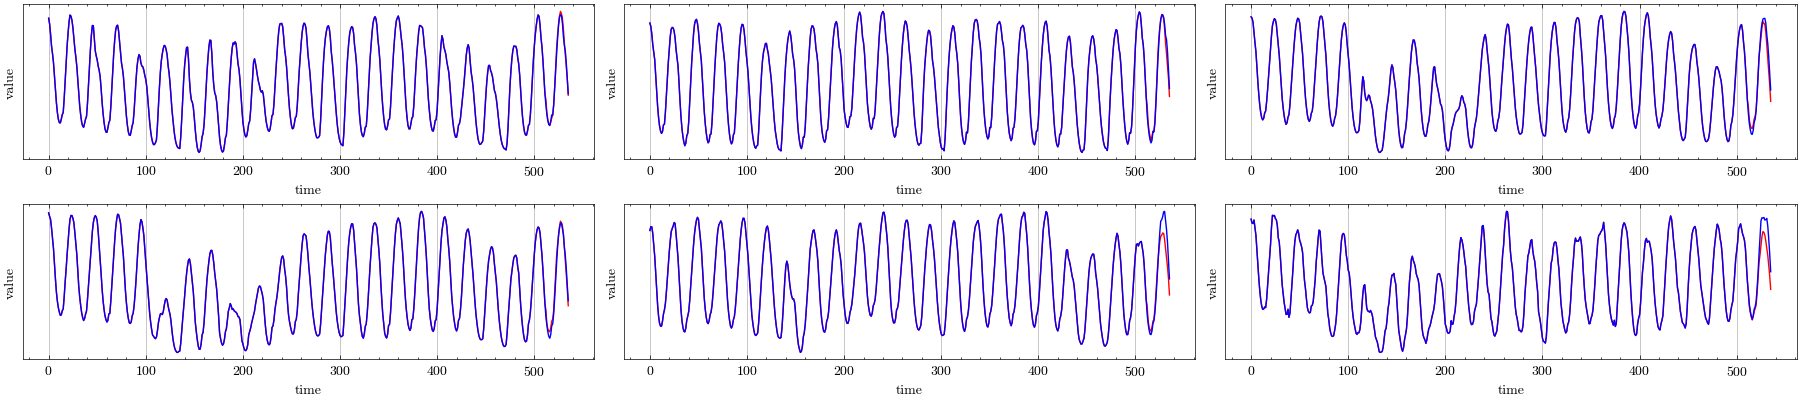

In [20]:
dataset = "ercot"
train_df = ww_dfs[dataset]["train_df"]
pred_df = ww_dfs[dataset]["pred_df"]
ids = np.random.choice(train_df['id'].unique(), sampled_ids, replace=False)
print(ids)
plt.subplots(2, int(np.ceil(sampled_ids/2)), figsize=(18, 4))
for i, idx in enumerate(ids):
    plt.subplot(2, np.ceil(sampled_ids/2), i+1)
    preds = pd.concat([train_df[train_df['id'] == idx], pred_df[pred_df['id'] == idx]]).reset_index()
    sns.lineplot(preds['pred'], c='red')
    sns.lineplot(preds['target'], c='blue')
    plt.xlabel('time')
    plt.ylabel('value')
    plt.yticks([])
    plt.legend()
    plt.grid(True)

### Tourism_quarterly

Given that the pattern is very similar to sine wave experiments we have seen, and tourism quartery is sampled every 3 months, we need to include that in sampling our date time info

[346 106 311 313  99  77]


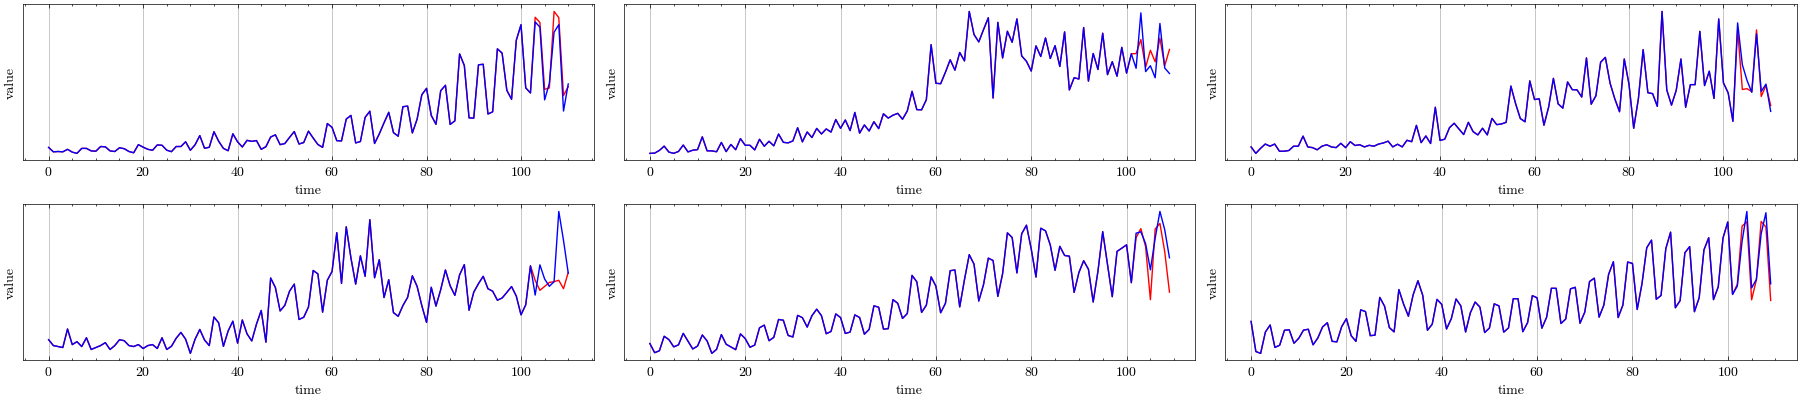

In [21]:
dataset = "tourism_quarterly"
train_df = ww_dfs[dataset]["train_df"]
pred_df = ww_dfs[dataset]["pred_df"]
ids = np.random.choice(train_df['id'].unique(), sampled_ids, replace=False)
print(ids)
plt.subplots(2, int(np.ceil(sampled_ids/2)), figsize=(18, 4))
for i, idx in enumerate(ids):
    plt.subplot(2, np.ceil(sampled_ids/2), i+1)
    preds = pd.concat([train_df[train_df['id'] == idx], pred_df[pred_df['id'] == idx]]).reset_index()
    sns.lineplot(preds['pred'], c='red')
    sns.lineplot(preds['target'], c='blue')
    plt.xlabel('time')
    plt.ylabel('value')
    plt.yticks([])
    plt.legend()
    plt.grid(True)

### Traffic

Two things can be noted:
- traffic dataset has 1H frequency which we didn't train on
- we didn't introduce high spikes in the data synthetic data or in other words, we didn't introduce data with very high variance across consecutive points as we see here

[ 595 4938 1520 4531 1057 2365]


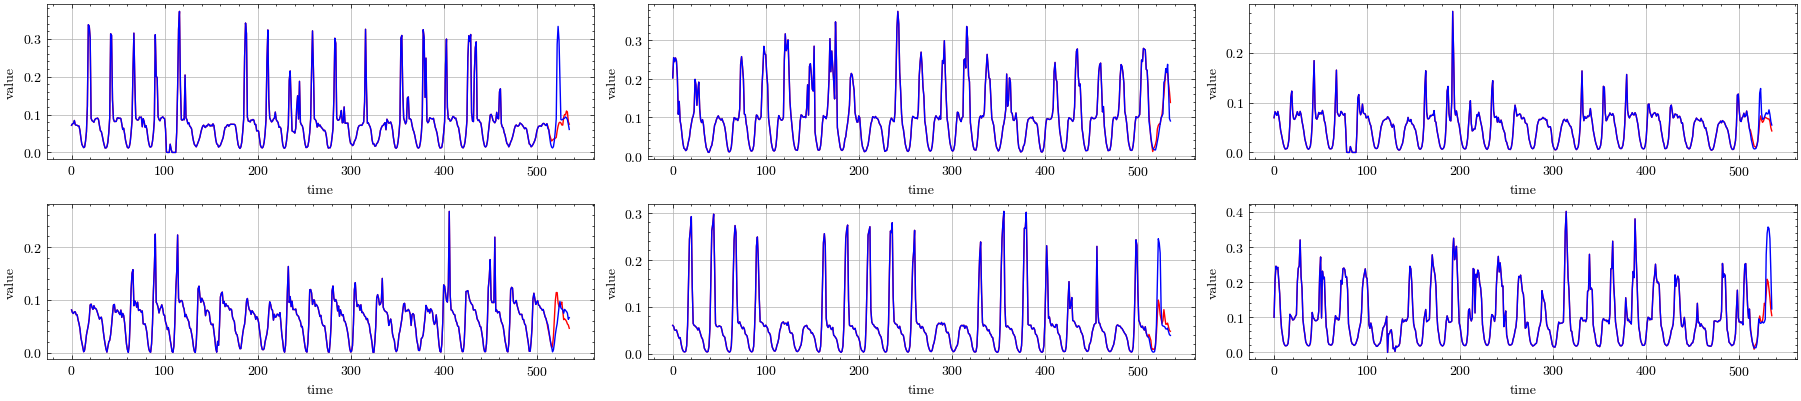

In [23]:
dataset = "traffic"
train_df = ww_dfs[dataset]["train_df"]
pred_df = ww_dfs[dataset]["pred_df"]
ids = np.random.choice(train_df['id'].unique(), sampled_ids, replace=False)
print(ids)
plt.subplots(2, int(np.ceil(sampled_ids/2)), figsize=(18, 4))
for i, idx in enumerate(ids):
    plt.subplot(2, np.ceil(sampled_ids/2), i+1)
    preds = pd.concat([train_df[train_df['id'] == idx], pred_df[pred_df['id'] == idx]]).reset_index()
    sns.lineplot(preds['pred'], c='red')
    sns.lineplot(preds['target'], c='blue')
    plt.xlabel('time')
    plt.ylabel('value')
    plt.legend()
    plt.grid(True)

### nn5_daily_without_missing

Very high frequency fluctuations which is not common in our synthetic datasets

[ 67   5 102  47  31  91]


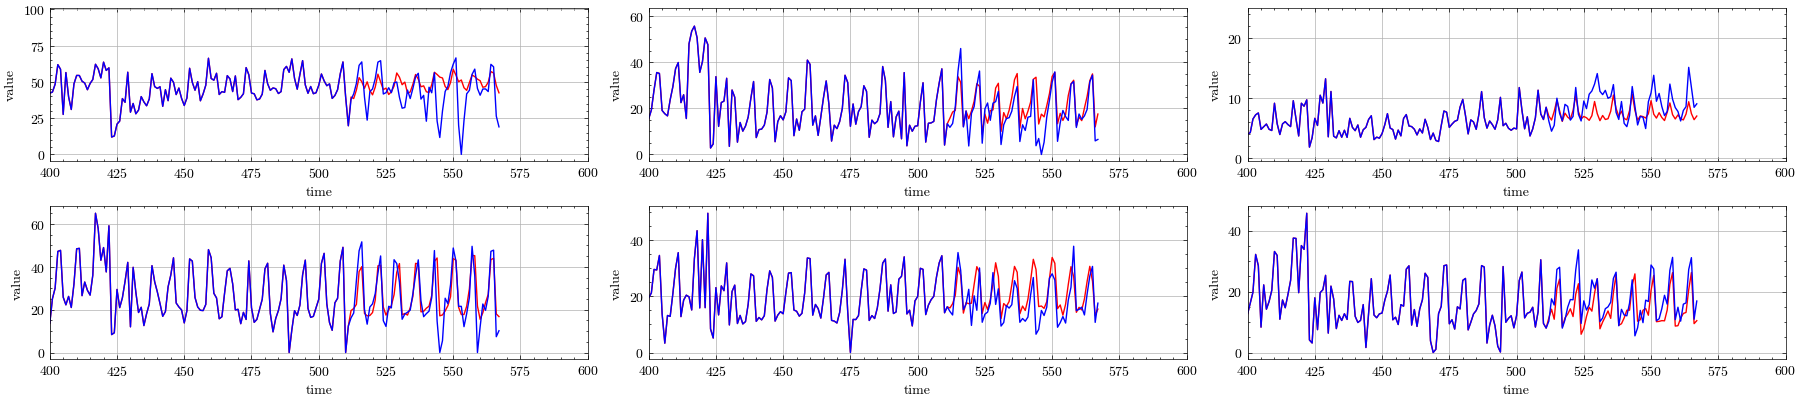

In [25]:
dataset = "nn5_daily_without_missing"
train_df = ww_dfs[dataset]["train_df"]
pred_df = ww_dfs[dataset]["pred_df"]
ids = np.random.choice(train_df['id'].unique(), sampled_ids, replace=False)
print(ids)
plt.subplots(2, int(np.ceil(sampled_ids/2)), figsize=(18, 4))
for i, idx in enumerate(ids):
    plt.subplot(2, np.ceil(sampled_ids/2), i+1)
    preds = pd.concat([train_df[train_df['id'] == idx], pred_df[pred_df['id'] == idx]]).reset_index()
    sns.lineplot(preds['pred'], c='red')
    sns.lineplot(preds['target'], c='blue')
    plt.xlabel('time')
    plt.ylabel('value')
    plt.xlim(400,600)
    plt.legend()
    plt.grid(True)

### m1_quarterly

the left-most ones (134 and 116) seem weird, MambaPFN probably doesn't like predicting constant linear values, maybe just linear trends with spikey signal in between should be introduced?

Also, note the sampling difference

[ 96 126 145 140 187 141]


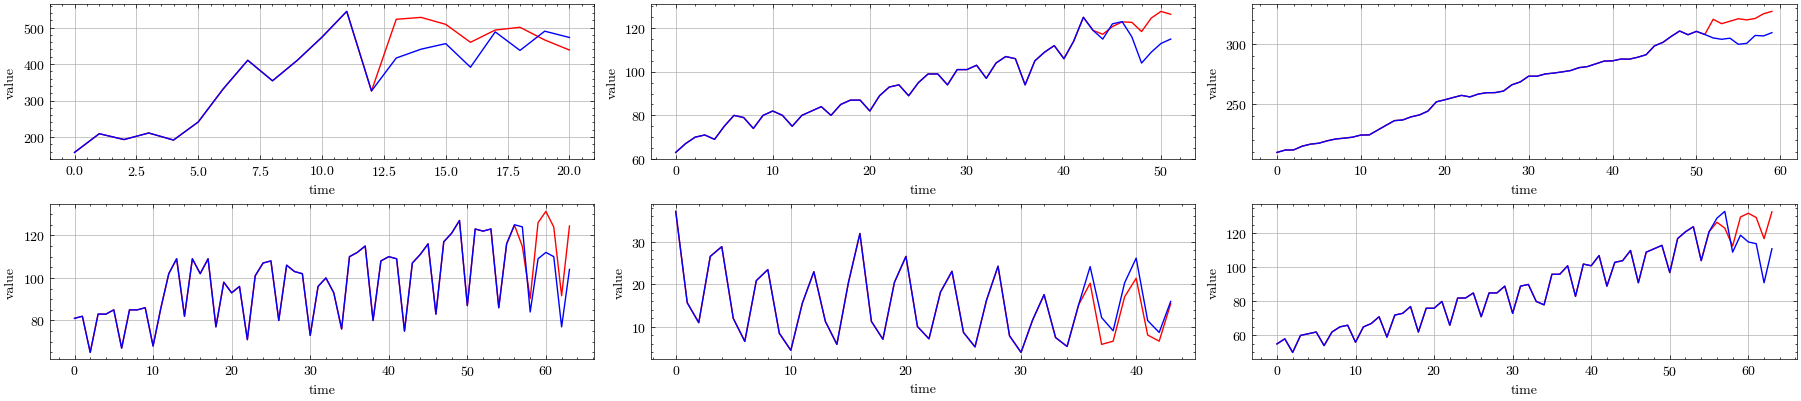

In [26]:
dataset = "m1_quarterly"
train_df = ww_dfs[dataset]["train_df"]
pred_df = ww_dfs[dataset]["pred_df"]
ids = np.random.choice(train_df['id'].unique(), sampled_ids, replace=False)
print(ids)
plt.subplots(2, int(np.ceil(sampled_ids/2)), figsize=(18, 4))
for i, idx in enumerate(ids):
    plt.subplot(2, np.ceil(sampled_ids/2), i+1)
    preds = pd.concat([train_df[train_df['id'] == idx], pred_df[pred_df['id'] == idx]]).reset_index()
    sns.lineplot(preds['pred'], c='red')
    sns.lineplot(preds['target'], c='blue')
    plt.xlabel('time')
    plt.ylabel('value')
    plt.legend()
    plt.grid(True)

### m3_quarterly

I guess besides the linear point mentioned above there is no negative comment that much

[582 281 689 211 373 646]


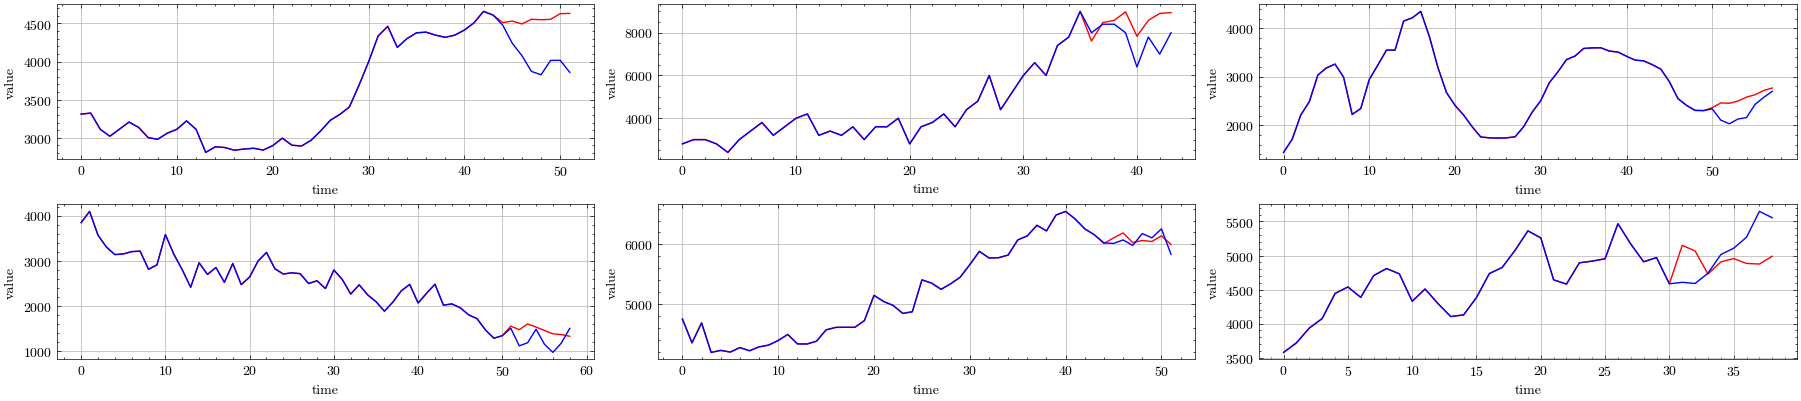

In [27]:
dataset = "m3_quarterly"
train_df = ww_dfs[dataset]["train_df"]
pred_df = ww_dfs[dataset]["pred_df"]
ids = np.random.choice(train_df['id'].unique(), sampled_ids, replace=False)
print(ids)
plt.subplots(2, int(np.ceil(sampled_ids/2)), figsize=(18, 4))
for i, idx in enumerate(ids):
    plt.subplot(2, np.ceil(sampled_ids/2), i+1)
    preds = pd.concat([train_df[train_df['id'] == idx], pred_df[pred_df['id'] == idx]]).reset_index()
    sns.lineplot(preds['pred'], c='red')
    sns.lineplot(preds['target'], c='blue')
    plt.xlabel('time')
    plt.ylabel('value')
    plt.legend()
    plt.grid(True)

## Worse datasets

In [28]:
w_dfs = {}

for dataset in list(df_joint.dataset.values):
    pl = REAL_DATASETS[dataset]
    w_dfs[dataset] = {}
    w_dfs[dataset]["train_df"] = pd.read_csv(f'../../data/real_data_evals/{model_name}/{pred_style}/{dataset}_train_df_{cl}_{pl}.csv')
    w_dfs[dataset]["pred_df"] = pd.read_csv(f'../../data/real_data_evals/{model_name}/{pred_style}/{dataset}_pred_df_{cl}_{pl}.csv')
    w_dfs[dataset]["train_df"]['pred'] = w_dfs[dataset]["train_df"]['target']
    

### Weather dataset

We are probably worse cause we never trained on spiky priors, not sure what kind of weather is that tho :D

[ 598 1205 1681 1086 1569 1730]


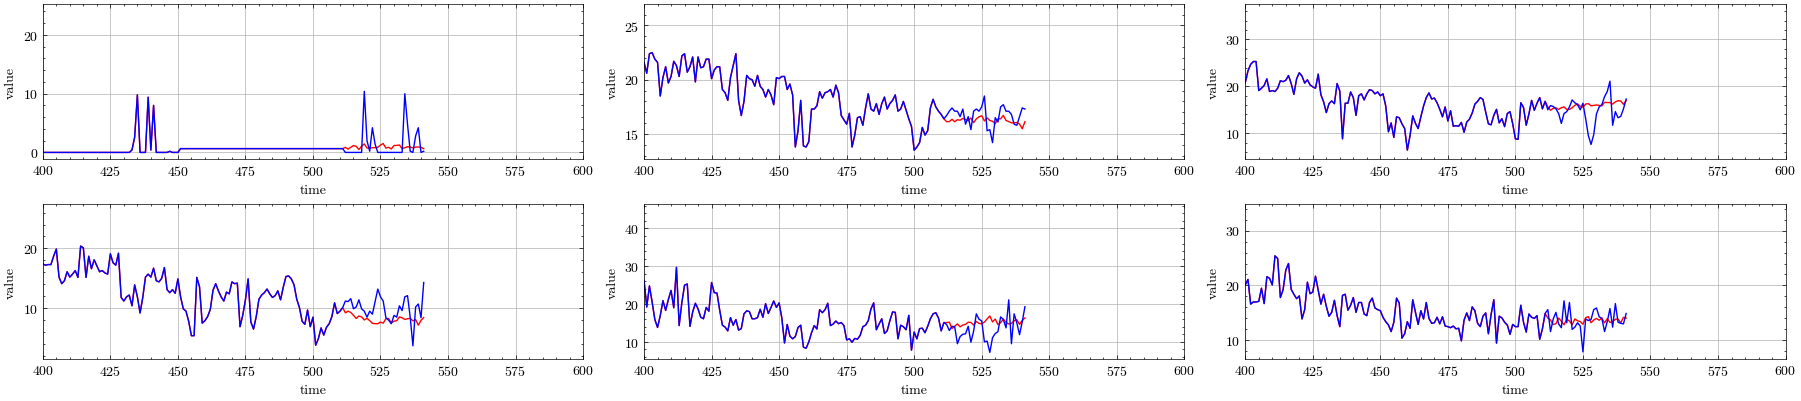

In [31]:
dataset = "weather"
train_df = w_dfs[dataset]["train_df"]
pred_df = w_dfs[dataset]["pred_df"]
ids = np.random.choice(train_df['id'].unique(), sampled_ids, replace=False)
print(ids)
plt.subplots(2, int(np.ceil(sampled_ids/2)), figsize=(18, 4))
for i, idx in enumerate(ids):
    plt.subplot(2, np.ceil(sampled_ids/2), i+1)
    preds = pd.concat([train_df[train_df['id'] == idx], pred_df[pred_df['id'] == idx]]).reset_index()
    sns.lineplot(preds['pred'], c='red')
    sns.lineplot(preds['target'], c='blue')
    plt.xlabel('time')
    plt.ylabel('value')
    plt.xlim(400,600)
    plt.legend()
    plt.grid(True)

### Car_parts_without_missing

It seems that the spikes issues still persist but this time the frequency of spikes are less and more interleaved

[2424  726 1707 2271 1304 1103]


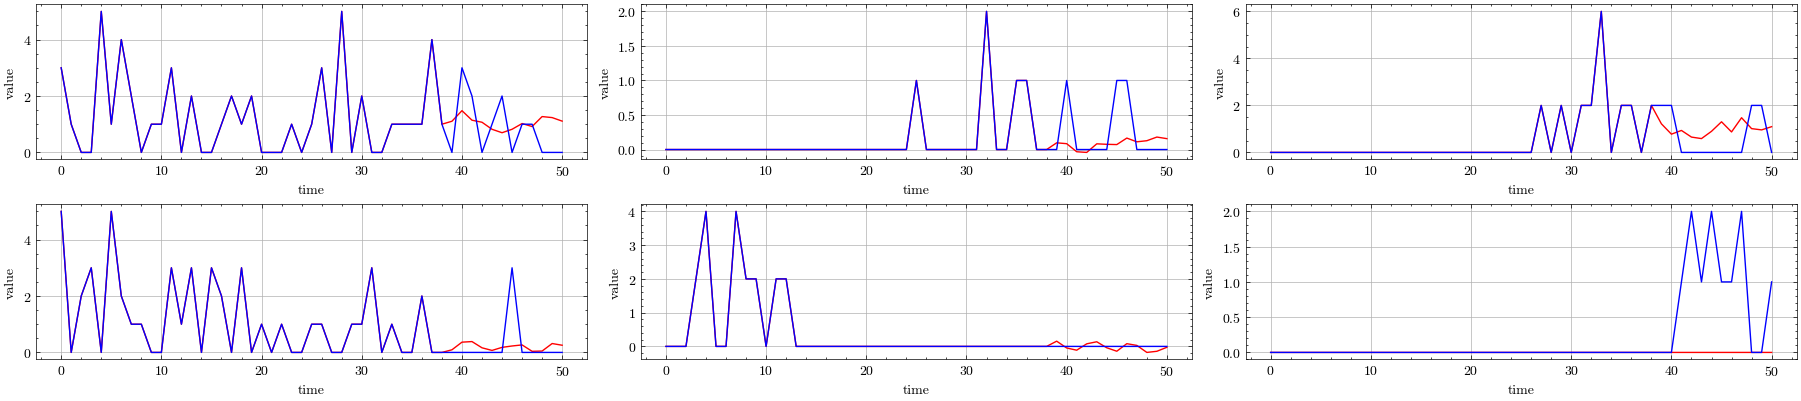

In [32]:
dataset = "car_parts_without_missing"
train_df = w_dfs[dataset]["train_df"]
pred_df = w_dfs[dataset]["pred_df"]
ids = np.random.choice(train_df['id'].unique(), sampled_ids, replace=False)
print(ids)
plt.subplots(2, int(np.ceil(sampled_ids/2)), figsize=(18, 4))
for i, idx in enumerate(ids):
    plt.subplot(2, np.ceil(sampled_ids/2), i+1)
    preds = pd.concat([train_df[train_df['id'] == idx], pred_df[pred_df['id'] == idx]]).reset_index()
    sns.lineplot(preds['pred'], c='red')
    sns.lineplot(preds['target'], c='blue')
    plt.xlabel('time')
    plt.ylabel('value')
    plt.legend()
    plt.grid(True)

## Nearly Equal and Better datasets


In [34]:
list(df_joint.dataset.values)

['nn5_daily_without_missing',
 'nn5_weekly',
 'covid_deaths',
 'weather',
 'hospital',
 'fred_md',
 'car_parts_without_missing',
 'traffic',
 'm3_monthly',
 'ercot',
 'm1_monthly',
 'm1_quarterly',
 'cif_2016',
 'exchange_rate',
 'm3_quarterly',
 'tourism_monthly',
 'tourism_quarterly']

In [33]:
e_b_dfs = {}

for dataset in list(df_joint.dataset.values):
    pl = REAL_DATASETS[dataset]
    e_b_dfs[dataset] = {}
    e_b_dfs[dataset]["train_df"] = pd.read_csv(f'../../data/real_data_evals/{model_name}/{pred_style}/{dataset}_train_df_{cl}_{pl}.csv')
    e_b_dfs[dataset]["pred_df"] = pd.read_csv(f'../../data/real_data_evals/{model_name}/{pred_style}/{dataset}_pred_df_{cl}_{pl}.csv')
    e_b_dfs[dataset]["train_df"]['pred'] = e_b_dfs[dataset]["train_df"]['target']
    

### nn5_weekly

I think also chronos is bad on it but honestly there is no evident patter to follow

[ 80  38  48 106  79  55]


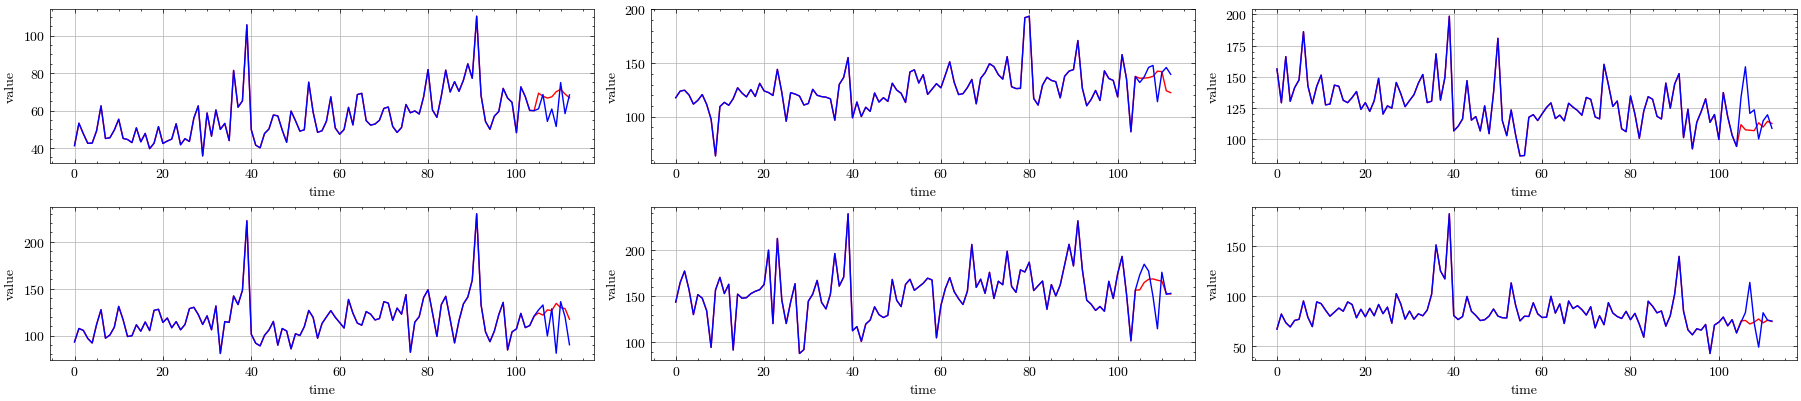

In [34]:
dataset = "nn5_weekly"
train_df = e_b_dfs[dataset]["train_df"]
pred_df = e_b_dfs[dataset]["pred_df"]
ids = np.random.choice(train_df['id'].unique(), sampled_ids, replace=False)
print(ids)
plt.subplots(2, int(np.ceil(sampled_ids/2)), figsize=(18, 4))
for i, idx in enumerate(ids):
    plt.subplot(2, np.ceil(sampled_ids/2), i+1)
    preds = pd.concat([train_df[train_df['id'] == idx], pred_df[pred_df['id'] == idx]]).reset_index()
    sns.lineplot(preds['pred'], c='red')
    sns.lineplot(preds['target'], c='blue')
    plt.xlabel('time')
    plt.ylabel('value')
    plt.legend()
    plt.grid(True)

### hospital

I guess by increasing the wiggles frequencies things can be better

[189 357 632 233 681 628]


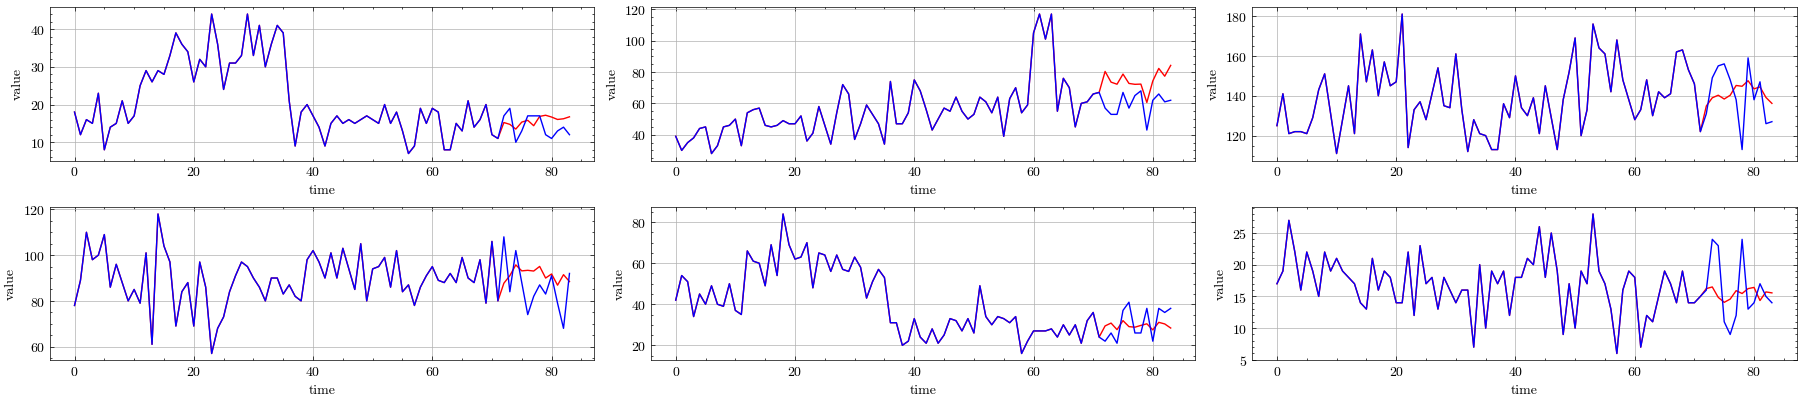

In [36]:
dataset = "hospital"
train_df = e_b_dfs[dataset]["train_df"]
pred_df = e_b_dfs[dataset]["pred_df"]
ids = np.random.choice(train_df['id'].unique(), sampled_ids, replace=False)
print(ids)
plt.subplots(2, int(np.ceil(sampled_ids/2)), figsize=(18, 4))
for i, idx in enumerate(ids):
    plt.subplot(2, np.ceil(sampled_ids/2), i+1)
    preds = pd.concat([train_df[train_df['id'] == idx], pred_df[pred_df['id'] == idx]]).reset_index()
    sns.lineplot(preds['pred'], c='red')
    sns.lineplot(preds['target'], c='blue')
    plt.xlabel('time')
    plt.ylabel('value')
    plt.legend()
    plt.grid(True)

### fred_md

fred_md nearly shows a similar trend but with the difference of having small noise and perturbations over it and no spikes .. the extra smoothness mixed with spikes makes things harder

[105  45   3  86  87  29]


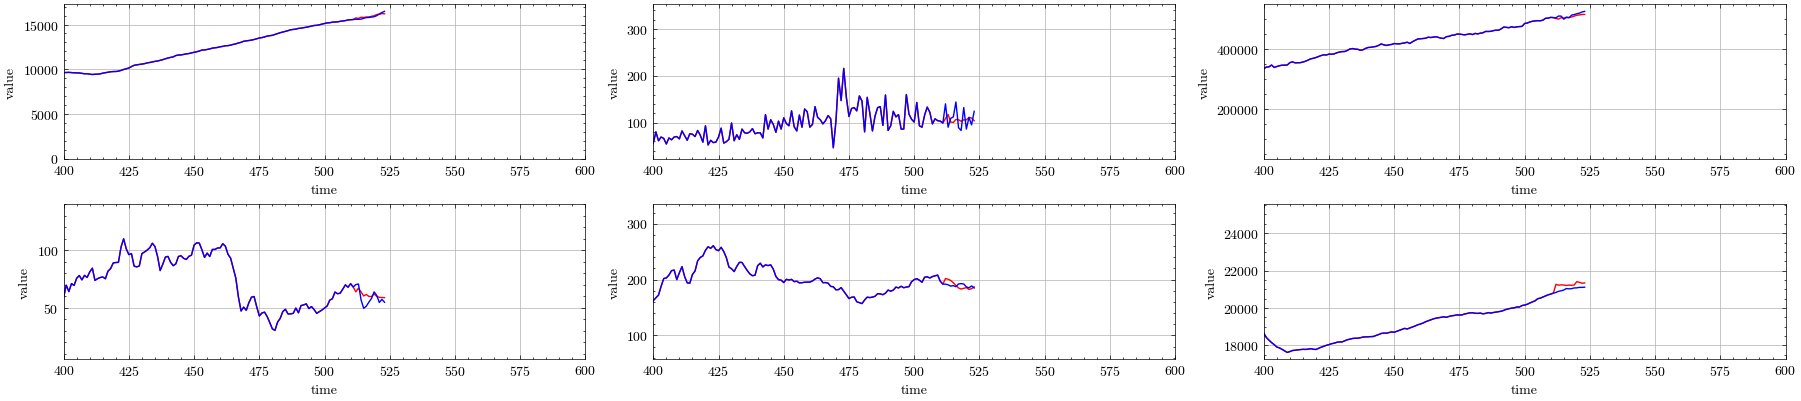

In [38]:
dataset = "fred_md"
train_df = e_b_dfs[dataset]["train_df"]
pred_df = e_b_dfs[dataset]["pred_df"]
ids = np.random.choice(train_df['id'].unique(), sampled_ids, replace=False)
print(ids)
plt.subplots(2, int(np.ceil(sampled_ids/2)), figsize=(18, 4))
for i, idx in enumerate(ids):
    plt.subplot(2, np.ceil(sampled_ids/2), i+1)
    preds = pd.concat([train_df[train_df['id'] == idx], pred_df[pred_df['id'] == idx]]).reset_index()
    sns.lineplot(preds['pred'], c='red')
    sns.lineplot(preds['target'], c='blue')
    plt.xlabel('time')
    plt.ylabel('value')
    plt.xlim(400,600)
    plt.legend()
    plt.grid(True)

### m3_monthly

[818 270 565 205 953 251]


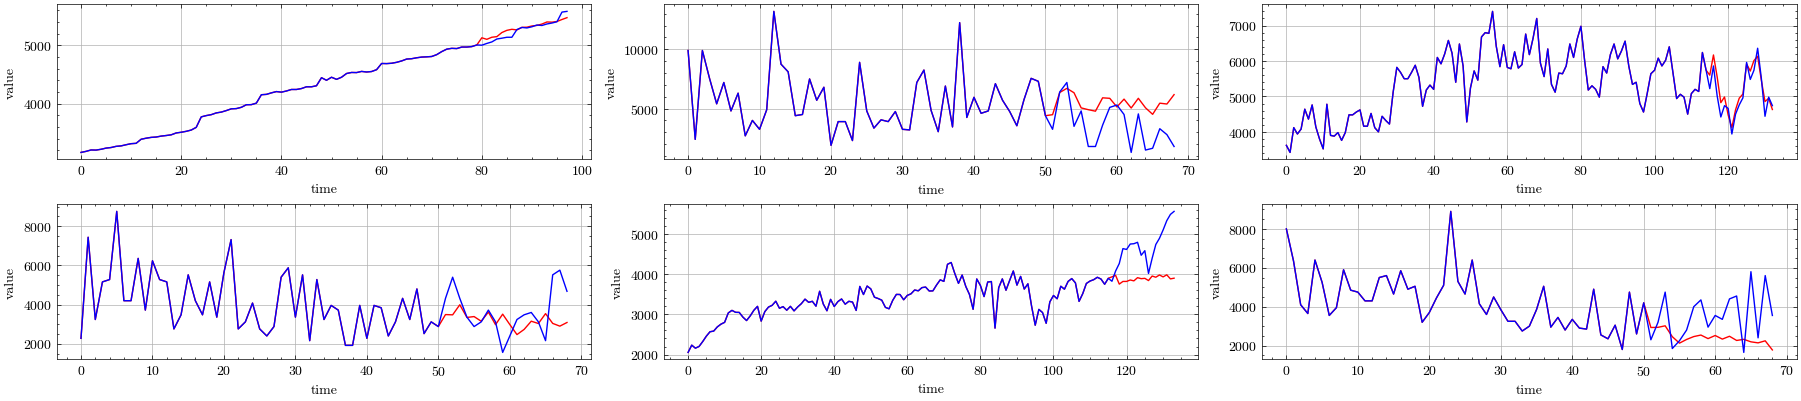

In [40]:
dataset = "m3_monthly"
train_df = e_b_dfs[dataset]["train_df"]
pred_df = e_b_dfs[dataset]["pred_df"]
ids = np.random.choice(train_df['id'].unique(), sampled_ids, replace=False)
print(ids)
plt.subplots(2, int(np.ceil(sampled_ids/2)), figsize=(18, 4))
for i, idx in enumerate(ids):
    plt.subplot(2, np.ceil(sampled_ids/2), i+1)
    preds = pd.concat([train_df[train_df['id'] == idx], pred_df[pred_df['id'] == idx]]).reset_index()
    sns.lineplot(preds['pred'], c='red')
    sns.lineplot(preds['target'], c='blue')
    plt.xlabel('time')
    plt.ylabel('value')
    plt.legend()
    plt.grid(True)

### m1_monthly

[ 15  89 511 502 325 199]


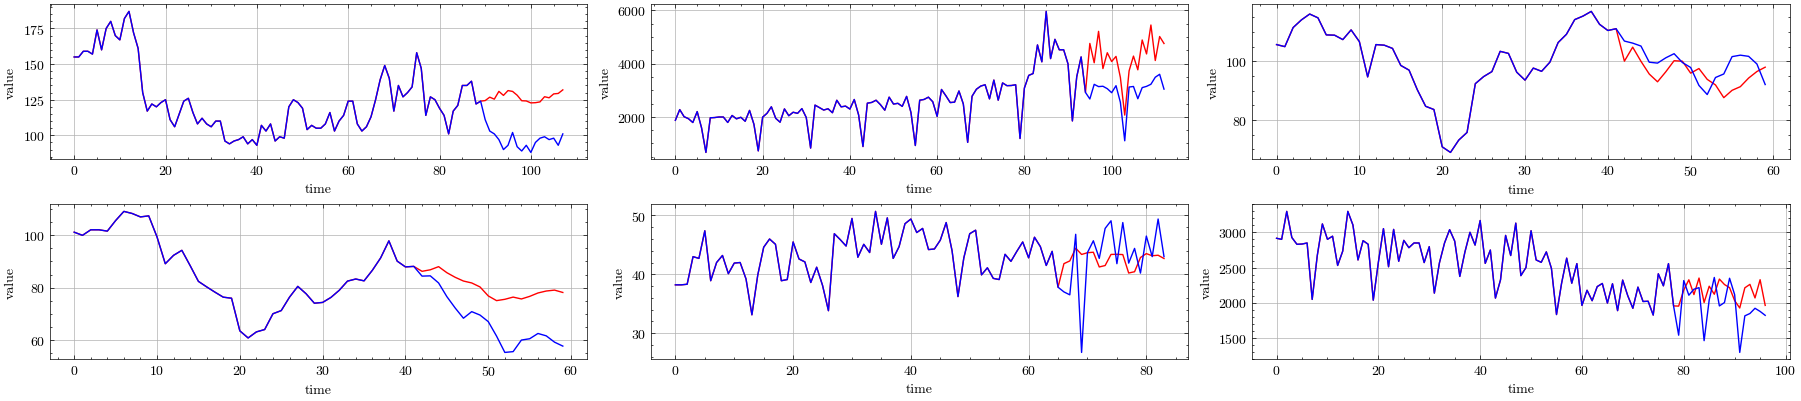

In [41]:
dataset = "m1_monthly"
train_df = e_b_dfs[dataset]["train_df"]
pred_df = e_b_dfs[dataset]["pred_df"]
ids = np.random.choice(train_df['id'].unique(), sampled_ids, replace=False)
print(ids)
plt.subplots(2, int(np.ceil(sampled_ids/2)), figsize=(18, 4))
for i, idx in enumerate(ids):
    plt.subplot(2, np.ceil(sampled_ids/2), i+1)
    preds = pd.concat([train_df[train_df['id'] == idx], pred_df[pred_df['id'] == idx]]).reset_index()
    sns.lineplot(preds['pred'], c='red')
    sns.lineplot(preds['target'], c='blue')
    plt.xlabel('time')
    plt.ylabel('value')
    plt.legend()
    plt.grid(True)

### cif_2016


[29 35 45  6 34 43]


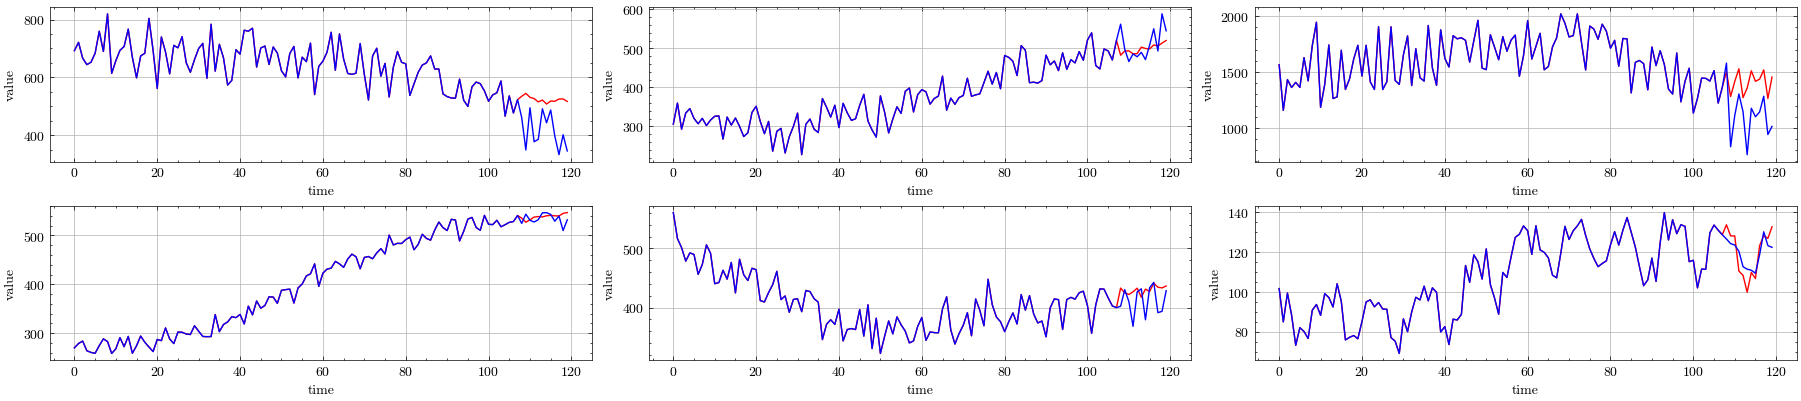

In [43]:
dataset = "cif_2016"
train_df = e_b_dfs[dataset]["train_df"]
pred_df = e_b_dfs[dataset]["pred_df"]
ids = np.random.choice(train_df['id'].unique(), sampled_ids, replace=False)
print(ids)
plt.subplots(2, int(np.ceil(sampled_ids/2)), figsize=(18, 4))
for i, idx in enumerate(ids):
    plt.subplot(2, np.ceil(sampled_ids/2), i+1)
    preds = pd.concat([train_df[train_df['id'] == idx], pred_df[pred_df['id'] == idx]]).reset_index()
    sns.lineplot(preds['pred'], c='red')
    sns.lineplot(preds['target'], c='blue')
    plt.xlabel('time')
    plt.ylabel('value')
    plt.legend()
    plt.grid(True)

### exchange_rate

[19 29 22  4  6 16]


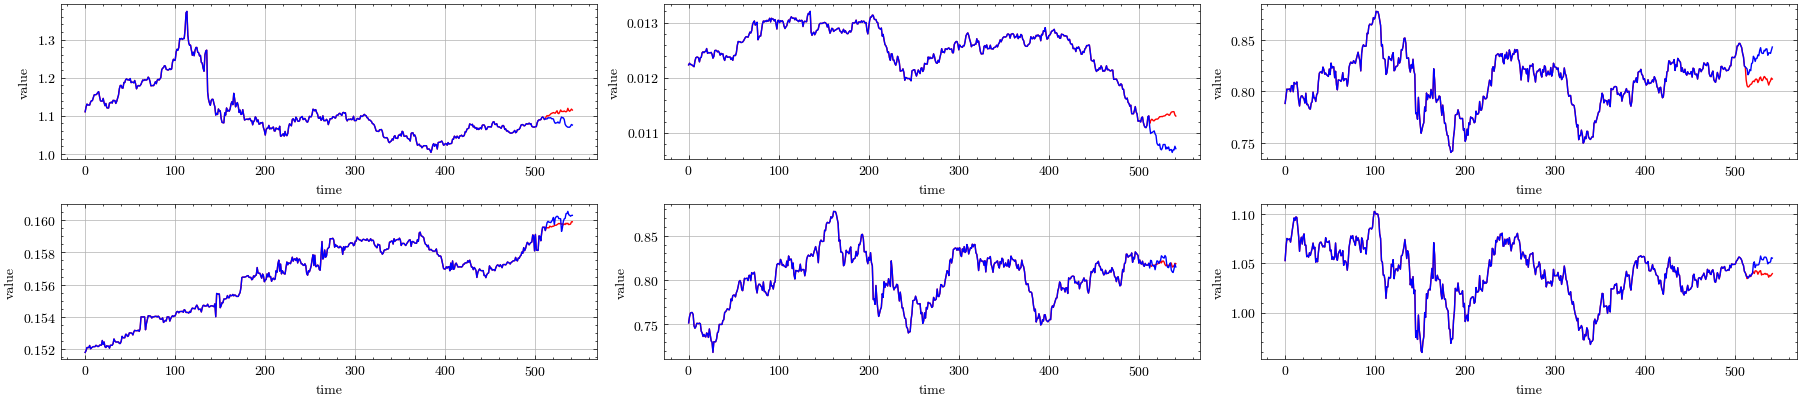

In [45]:
dataset = "exchange_rate"
train_df = e_b_dfs[dataset]["train_df"]
pred_df = e_b_dfs[dataset]["pred_df"]
ids = np.random.choice(train_df['id'].unique(), sampled_ids, replace=False)
print(ids)
plt.subplots(2, int(np.ceil(sampled_ids/2)), figsize=(18, 4))
for i, idx in enumerate(ids):
    plt.subplot(2, np.ceil(sampled_ids/2), i+1)
    preds = pd.concat([train_df[train_df['id'] == idx], pred_df[pred_df['id'] == idx]]).reset_index()
    sns.lineplot(preds['pred'], c='red')
    sns.lineplot(preds['target'], c='blue')
    plt.xlabel('time')
    plt.ylabel('value')
    plt.legend()
    plt.grid(True)

### tourism_monthly

[162  45 318 348  58 118]


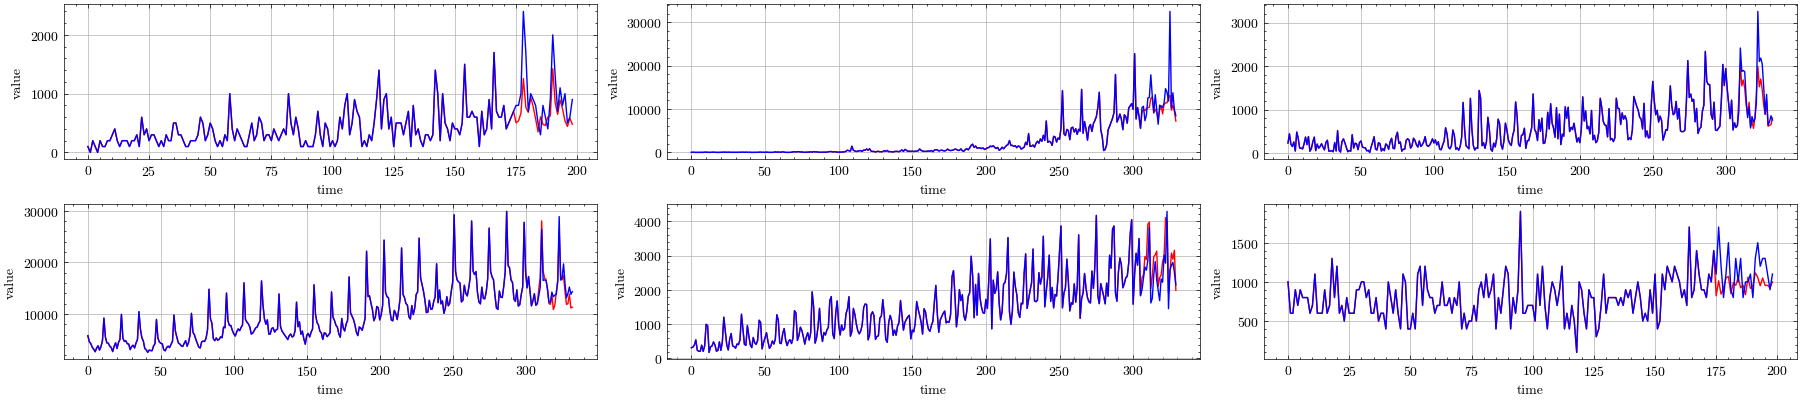

In [47]:
dataset = "tourism_monthly"
train_df = e_b_dfs[dataset]["train_df"]
pred_df = e_b_dfs[dataset]["pred_df"]
ids = np.random.choice(train_df['id'].unique(), sampled_ids, replace=False)
print(ids)
plt.subplots(2, int(np.ceil(sampled_ids/2)), figsize=(18, 4))
for i, idx in enumerate(ids):
    plt.subplot(2, np.ceil(sampled_ids/2), i+1)
    preds = pd.concat([train_df[train_df['id'] == idx], pred_df[pred_df['id'] == idx]]).reset_index()
    sns.lineplot(preds['pred'], c='red')
    sns.lineplot(preds['target'], c='blue')
    plt.xlabel('time')
    plt.ylabel('value')
    plt.legend()
    plt.grid(True)